In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
random_number = random.randint(1, 11)           # Generates a random number between 1 and 11
cards = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4     # The 52 deck of cards excluding the 2 jokers. And the 4 times duplicated 10 denotes the j , Q , K and Number 10 card values 
card_counting_memory = []                       # A 1D array using for the card counting

def Hit(cards):                                  # A function that is called when the dealer or player wants to Hit a card 
  if(len(cards) < 10):                                # This condition Renews the cards if the deck runs out of cards
    cards = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4
  rand = random.choice(cards)                         # Randomly picks a card from the cards array
  cards.remove(rand)                                  # Removes the picked card from the card array
  card_counting_memory.append(rand)                   # Adds the picked card into the card counting array
  return rand                                         # Returns the randomly picked card

def Game_Start():                                # Initializes the gameplay
  card_counting_memory = []                           
  Dealer = []                                         # A 1D array that Stores the card the dealer takes 
  Player = []                                         # A 1D array that Stores the card the player take
  for i in range(2):                                  # The player takes 2 cards when the game starts
    Player.append(Hit(cards))
  Dealer.append(Hit(cards))                           # The dealer takes 1 card when the game starts
  return Player,Dealer

def progress(player,dealer):                     # A function that is used for showing the current states of the player and the dealer
  player_progress = f"Player : {player}"              # outputs the players state
  dealer_progress = f"Dealer : {dealer}"              # outputs the dealers state
  return  dealer_progress , player_progress

def fill_zeros(player,dealer):                   # A function that converts the player and the dealer array into (1 x 15) by adding zeros into the array till the size becomes 15. 
  player = [i for i in player if i != 0]               # removes the previously added zeros       
  dealer = [i for i in dealer if i != 0]
  for i in range(15-len(player)):                      # A loop that appends zeros into the player array
    player.append(0)
  for i in range(15-len(dealer)):                      # A loop that appends zeros into the dealer array 
    dealer.append(0)
  return player,dealer                                 # Returns the the the player and dealer array with their modified lengths. 

def card_counting(card_counting_memory):   # A function that implements the card counting . The card counting is implemented by computing the mean value of the card_counting_memory array and removed cards
    sum_of_list = 0                              # A local variable which stores the total sum of the cards
    estimate = ""                                # A string that will hold the information about the remaining deck of card
    for i in range(len(card_counting_memory)):   # sums up all the values inside the array
        sum_of_list += card_counting_memory[i]
    memory_count = sum_of_list/len(card_counting_memory)  # Computes the mean
    if(memory_count < 6.5):                               # If the mean value of the card counting memory is less than 6.5 (The mean value of a deck of cards consisting 52 cards)
      estimate = "high"                                   # If condition is true it gives an information that there are a lot of cards with high face value 
    else:
      estimate = "low"                                    # Counter condition
    return estimate


class NeuralNet(nn.Module):                                     # Neural Network Class
  def __init__(self):
    super(NeuralNet,self).__init__()

    self.layer_1 = nn.Linear(15, 128)                # Initial input layer , recieves a (1 x 15) 1D array 
    self.relu = nn.ReLU()                            # a Relu activation function that eradicates the exponential growth of the computations inside the model   
    self.dropout = nn.Dropout(p=0.4)                 # a dropout layer that helps with overfitting problem
    self.layer_2 = nn.Linear(128, 1)                 # The second linear layer that spits a scalar prediction        
    self.sigmoid = nn.Sigmoid()                      # A sigmoid activation that converts the predictions into binary numbers

  def forward(self, input):                          # A function that stacks up all the previously initialized layers of our neural network                            
    out = self.layer_1(input)
    out = self.relu(out)
    nout = self.dropout(out)
    out = self.layer_2(out)
    out = self.sigmoid(out)
    return out   

model = NeuralNet()                   # Creats object of the NeuralNet model
Loss = nn.BCELoss()                   # A binary cross Entropy loss , Since our model outputs 0 or 1
learning_rate = 0.02                  # The step size of the gradient descent
optimizer = optim.Adam(model.parameters(), learning_rate)

def reward_generator(player):                                                # A function that gives rewards for the actions of the player (The rewards are 0 or 1)
  index = [0]
  if((sum(player) >= 18) and (card_counting(card_counting_memory) == "high")):   
    index[0] = 0
  if(sum(player) < 18):
    index[0] = 1
  return index

def Agent(Player,Dealer,reward):                      # A function that defines the agent . Takes in the player's ,dealers card and the reward of their actions
  player,dealer = fill_zeros(Player,Dealer)           # Converts the 1D array into a tensor
  train_set = torch.tensor(player)                    
  reward = torch.tensor(reward)                       # The reward is also converted into a tensor

  pred = model.forward(train_set.float())             # The tensors are fed into the model
  loss = Loss(pred,reward.float())                    # The loss is calculated

  out = torch.round(pred)
  decision = "Hit" if out == 1 else "Stand"           # The decision of the model is converted into a string value
  print(f"*** The Player Decided to {decision}")

  #Backward (get gradients)
  optimizer.zero_grad()                               
  loss.backward()                                     # Backpropagtion(gradient descent) is done 

  #SGD Update Weights
  optimizer.step()
  buffer.append(loss.item())                          # The losses are appended into a loss array for visualization purpose
  return out

def winner(player,dealer):                            # A function the holds all the game rules of blackjack . Once the player and the dealers cards are inputted to it returns a string with an oinformation of the winner
  output=""
  if(len(player) == 2 and sum(player) == 21):          
    output = "BLACKJACK !! Player Won"
  if((sum(player) > sum(dealer) and (sum(player) <= 21)) or ((sum(player) <= 21) and (sum(dealer) > 21))):
    output = "Player Won"
  if(sum(dealer) > sum(player) and (sum(dealer) <= 21) or ((sum(player) > 21) and (sum(dealer) <= 21))):
    output = "Dealer Won"
  if(sum(player) > 21 and sum(dealer) > 21):
    if(sum(player) < sum(dealer)):
      output = "Player Won"
    elif(sum(player) > sum(dealer)):
      output = "Dealer Won"
  if(sum(player) == sum(dealer)):
    output = "It is a Tie"
  return output

def play(num_of_games):                              # A function the executes the game. Takes a parameter which specifies the number of games to be played
  count = 0
  for i in range(num_of_games):                      # a loop which runs until the number of specified games end
    Player , Dealer = Game_Start()                   # The Game start function is called
    print(f"------------GAME Number {i}---------------")
    print(progress(Player,Dealer))                   # Displays the initial cards the player and dealer took
    reward  = reward_generator(Player)
    AI = Agent(Player,Dealer,reward)                 # The agent is called to decide for the inital cards 2 cards it got
    while(AI == 1):                           # The heartbeat of the whole function . It checks weather the Agent decides to Hit or stand . 1 represents a Hit
      Player.append(Hit(cards))               # If the Agent or model outputs a 1 (Hit) a card is appended into the player array
      print(progress(Player,Dealer))
      reward = reward_generator(Player)       # It recieves a reward for the decision
      
      AI = Agent(Player,Dealer,reward)        # After that this values are gain feed into the model so that he can learn from it's actions

    while((sum(Dealer) < 17) and (sum(Dealer) < sum(Player))):   # The condition is responsible for the dealers interaction 
      Dealer.append(Hit(cards))                                  # It appends a card into the dealers array  
      print(progress(Player,Dealer))                             # The progress of the game play is displayed
    
    game = winner(Player,Dealer)
    print(game)

    if(game == "Player Won"):                           # The accuracy is calculated
      count +=1
  accuracy = (count / num_of_games) * 100
  print(f"The accuracy is {accuracy}" )
  return Player,Dealer


# Run this cell to run the game

In [3]:
buffer = []                                 # Responsible for holding the bad actions . Helps us know how the player is improving through time 
start_player , start_dealer = Game_Start()  # The Game_start function is responsible for starting the game
player , dealer =  play(1000)               # The play function executes the game . and it's parameter denotes the number of games we want the player to play. 1000 in this case 

Streaming output truncated to the last 5000 lines.
('Dealer : [10]', 'Player : [10, 7, 7]')
*** The Player Decided to Stand
('Dealer : [10, 10]', 'Player : [10, 7, 7]')
Dealer Won
------------GAME Number 408---------------
('Dealer : [5]', 'Player : [4, 9]')
*** The Player Decided to Hit
('Dealer : [5]', 'Player : [4, 9, 10]')
*** The Player Decided to Stand
('Dealer : [5, 2]', 'Player : [4, 9, 10]')
('Dealer : [5, 2, 10]', 'Player : [4, 9, 10]')
Dealer Won
------------GAME Number 409---------------
('Dealer : [10]', 'Player : [1, 5]')
*** The Player Decided to Hit
('Dealer : [10]', 'Player : [1, 5, 8]')
*** The Player Decided to Stand
('Dealer : [10, 10]', 'Player : [1, 5, 8]')
Dealer Won
------------GAME Number 410---------------
('Dealer : [6]', 'Player : [4, 10]')
*** The Player Decided to Hit
('Dealer : [6]', 'Player : [4, 10, 10]')
*** The Player Decided to Stand
('Dealer : [6, 10]', 'Player : [4, 10, 10]')
('Dealer : [6, 10, 9]', 'Player : [4, 10, 10]')
Player Won
------------GA

Run this cell to display the Loss plot

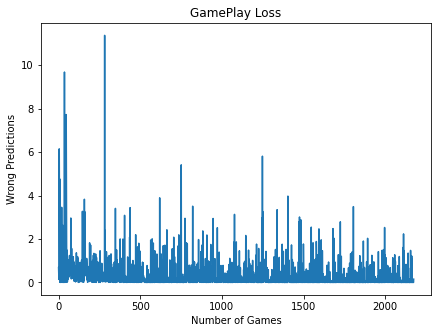

In [4]:
plt.figure(figsize=(7,5))
plt.title("GamePlay Loss")
plt.xlabel("Number of Games")
plt.ylabel("Wrong Predictions")
plt.plot(buffer)